In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
geojson_cycle_parking = gpd.read_file('data/cycle_parking.json')
geojson_tfl_stations = gpd.read_file('data/tfl_stations.json')
geojson_tfl_lines = gpd.read_file('data/tfl_lines.json')

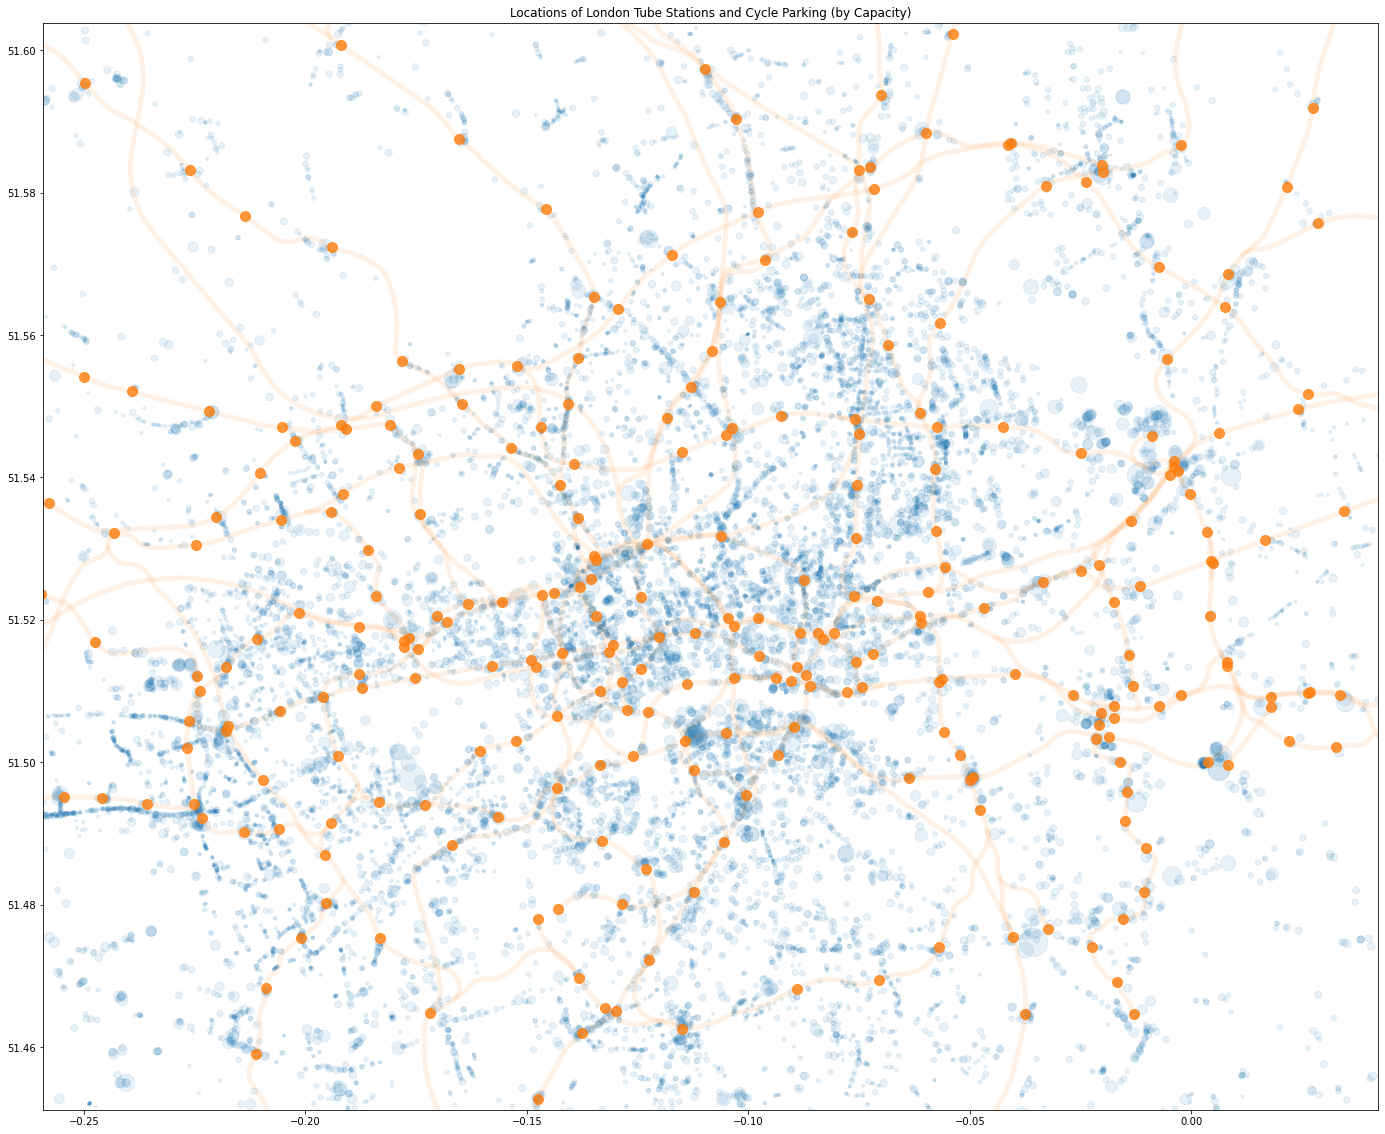

In [5]:
fig, ax = plt.subplots(figsize=(30, 20))

ALPHA_CYCLE_PARKING = 0.1
ALPHA_LINES = 0.1
ALPHA_STATIONS = 0.8
COLOR_CYCLE_PARKING = 'C0'
COLOR_LINES = 'C1'
COLOR_STATIONS = 'C1'
LINE_WIDTH_LINES = 5
MAP_SUBSET_OFFSET_X = 0.0
MAP_SUBSET_OFFSET_Y = 0.1
MAP_SUBSET_SIZE = 0.3
MARKER_SIZE_CYCLE_PARKING = 5
MARKER_SIZE_STATIONS = 100

def plot_background(ax):
    geojson_cycle_parking.plot(ax=ax, markersize=geojson_cycle_parking['PRK_CPT']*MARKER_SIZE_CYCLE_PARKING, alpha=ALPHA_LINES, color=COLOR_CYCLE_PARKING)
    geojson_tfl_lines.plot(ax=ax, linewidth=LINE_WIDTH_LINES, alpha=ALPHA_LINES, color=COLOR_LINES)
    
    x_min, y_min, x_max, y_max = geojson_cycle_parking.total_bounds
    dx = x_max - x_min
    dy = y_max - y_min
    
    ax.set_xlim(dx * MAP_SUBSET_SIZE + x_min, dx * (1 - MAP_SUBSET_SIZE) + x_min)
    ax.set_ylim(dy * MAP_SUBSET_SIZE + y_min + dy * MAP_SUBSET_OFFSET_Y, dy * (1 - MAP_SUBSET_SIZE) + y_min + dy * MAP_SUBSET_OFFSET_Y)

plot_background(ax)
geojson_tfl_stations.plot(ax=ax, markersize=MARKER_SIZE_STATIONS, alpha=ALPHA_STATIONS, color=COLOR_STATIONS)
ax.set_title('Locations of London Tube Stations and Cycle Parking (by Capacity)')
plt.draw()

In [6]:
# Load and preview London Tube station tap count data.
taps = pd.read_csv('data/tfl-foi-2020/FOI 1760-2021.csv', dayfirst=True)
taps.head()

,Travel Location Name,Travel Location No,Transport Mode,Travel Date,Transaction Type,Count of Taps
0,Abbey Road DLR,750,Rail,01/01/2020 00:00,Exit,224
1,Abbey Road DLR,750,Rail,01/01/2020 00:00,PVal,230
2,Abbey Road DLR,750,Rail,01/01/2020 00:00,Entry,229
3,Abbey Road DLR,750,Rail,02/01/2020 00:00,Exit,406
4,Abbey Road DLR,750,Rail,02/01/2020 00:00,PVal,552


In [7]:
# Clean stations data.
stations = geojson_tfl_stations[['name', 'nlc_id', 'geometry']]
stations = stations[stations['nlc_id'].notna()]
stations = stations[stations['nlc_id'].str.isnumeric()]
stations['nlc_id'] = pd.to_numeric(stations['nlc_id'])
nlc_ids = set(stations['nlc_id'])

In [8]:
# Collect taps for stations available.
taps = taps[['Travel Location Name', 'Travel Location No', 'Travel Date', 'Transaction Type', 'Count of Taps']].rename(columns={
    'Travel Location Name': 'name',
    'Travel Location No': 'nlc_id',
    'Travel Date': 'date',
    'Transaction Type': 'transaction_type',
    'Count of Taps': 'tap_count',
})
taps = taps[taps['nlc_id'].isin(nlc_ids)]
taps.head()

,name,nlc_id,date,transaction_type,tap_count
0,Abbey Road DLR,750,01/01/2020 00:00,Exit,224
1,Abbey Road DLR,750,01/01/2020 00:00,PVal,230
2,Abbey Road DLR,750,01/01/2020 00:00,Entry,229
3,Abbey Road DLR,750,02/01/2020 00:00,Exit,406
4,Abbey Road DLR,750,02/01/2020 00:00,PVal,552


In [9]:
# Aggregate entry taps by station.
taps_entry = taps[taps['transaction_type'] == 'Entry']
taps_entry_totals = taps_entry.groupby(['nlc_id']).agg({'tap_count': 'sum'}).reset_index()
taps_entry_totals.head()

,nlc_id,tap_count
0,500,1261745
1,501,1374137
2,502,1417383
3,503,1926314
4,504,235228


In [10]:
# Merge station geometries with entry counts.
stations_ridership = stations.merge(taps_entry_totals[['nlc_id', 'tap_count']], on='nlc_id', how='left')
stations_ridership = stations_ridership[~stations_ridership['tap_count'].isna()]
stations_ridership.describe()

,nlc_id,tap_count
count,489.000000,4.890000e+02
mean,2655.501022,1.090046e+06
std,3055.068037,1.593454e+06
min,500.000000,1.886000e+03
25%,623.000000,1.960540e+05
50%,758.000000,5.819100e+05
75%,5421.000000,1.211780e+06
max,9587.000000,1.266354e+07


In [11]:
# Naively normalize tap counts.
def scale(df, col):
    min_value = df[col].min()
    max_value = df[col].max()
    df['{}_scaled'.format(col)] = (df[col] - min_value) / (max_value - min_value)
    return df

stations_ridership = scale(stations_ridership, 'tap_count')

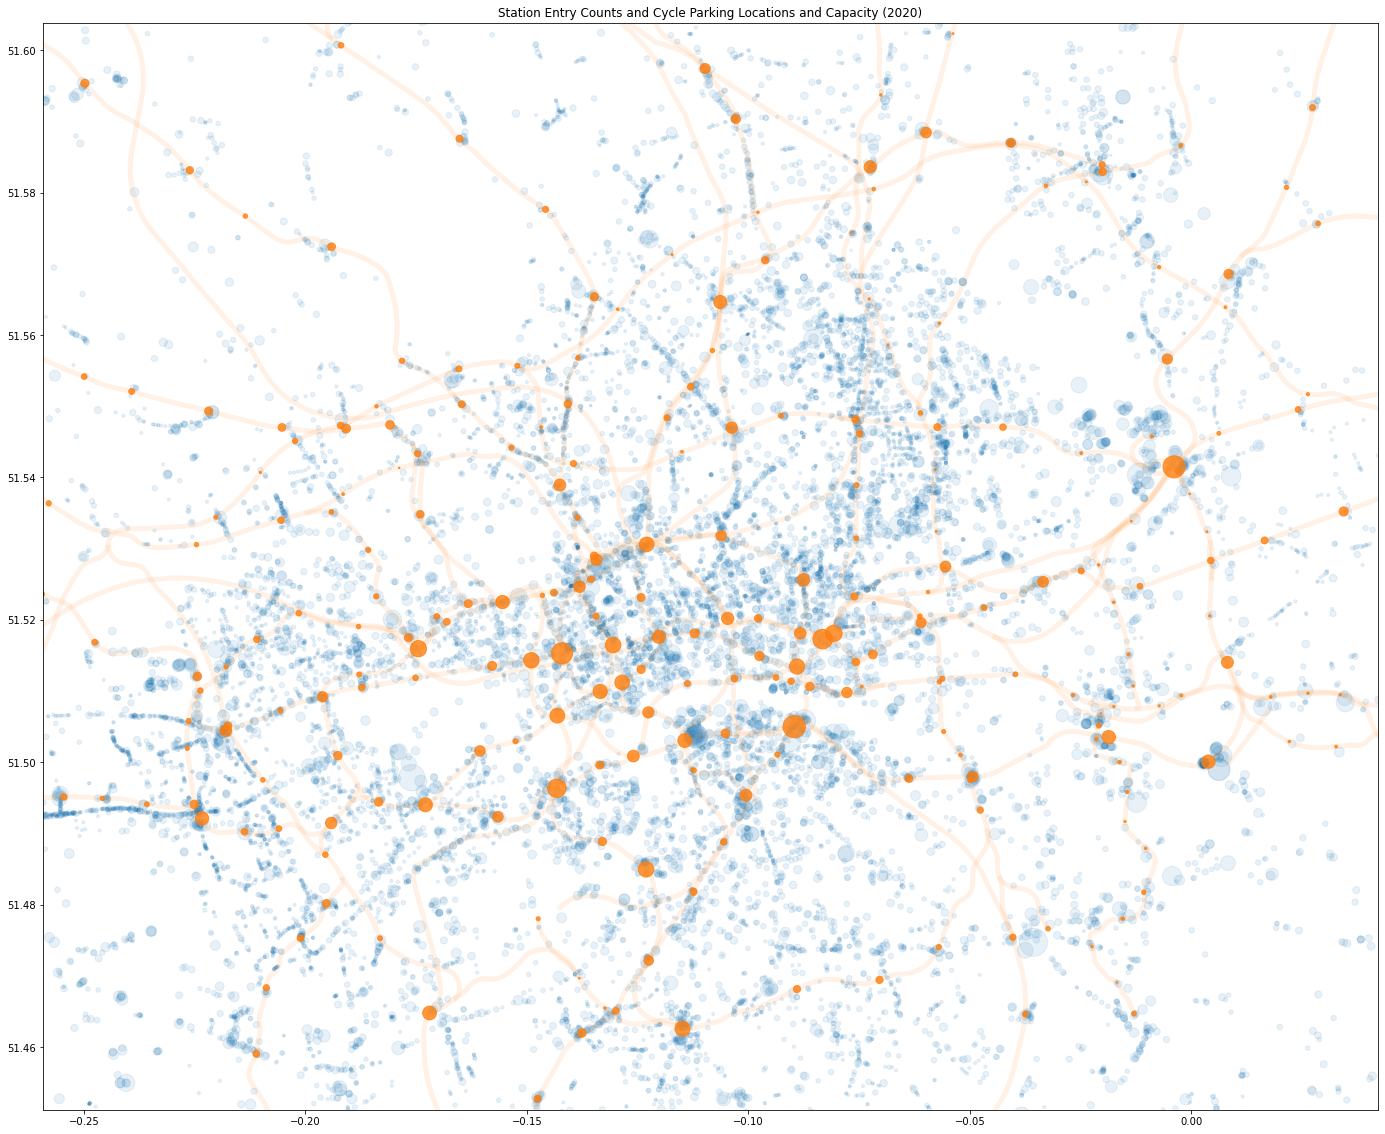

In [16]:
fig, ax = plt.subplots(figsize=(30, 20))

plot_background(ax)
stations_ridership.plot(ax=ax, markersize=stations_ridership['tap_count_scaled'] * MARKER_SIZE_STATIONS * 5, alpha=ALPHA_STATIONS, color=COLOR_STATIONS)
ax.set_title('Station Entry Counts and Cycle Parking Locations and Capacity (2020)')
plt.draw()

In [17]:
# Simplify for aggregation.
parking = geojson_cycle_parking[['PRK_CPT', 'geometry']].rename(columns={'PRK_CPT': 'capacity'})
parking.head()

,capacity,geometry
0,6.0,POINT (-0.24278 51.51032)
1,6.0,POINT (-0.24278 51.51026)
2,2.0,POINT (-0.24058 51.50147)
3,4.0,POINT (-0.23829 51.50650)
4,4.0,POINT (-0.23845 51.50628)


In [18]:
len(parking)

23758

In [19]:
len(stations_ridership)

489

In [21]:
# Collect parking geometries and capacities into list.
parking_tuples = [tuple(x) for x in parking[['geometry', 'capacity']].to_numpy()]

In [23]:
# Explode parking location and capacity list across every station.
stations_collect = stations_ridership.copy()
stations_collect['parking_tuples'] = ''
stations_collect['parking_tuples'] = stations_collect['parking_tuples'].astype('object')

for index, row in stations_collect.iterrows():
    stations_collect.at[index, 'parking_tuples'] = parking_tuples 
    
stations_collect = stations_collect[['nlc_id', 'parking_tuples']].explode('parking_tuples')
stations_collect[['point', 'capacity']] = pd.DataFrame(stations_collect['parking_tuples'].tolist(), index=stations_collect.index)
stations_collect.head()

,nlc_id,parking_tuples,point,capacity
0,500,"(POINT (-0.2427797672 51.5103212773), 6.0)",POINT (-0.2427797672 51.5103212773),6.0
0,500,"(POINT (-0.2427846609 51.5102610544), 6.0)",POINT (-0.2427846609 51.5102610544),6.0
0,500,"(POINT (-0.2405751224 51.5014706358), 2.0)",POINT (-0.2405751224 51.5014706358),2.0
0,500,"(POINT (-0.2382877591 51.5065007339), 4.0)",POINT (-0.2382877591 51.5065007339),4.0
0,500,"(POINT (-0.2384457427 51.5062848196), 4.0)",POINT (-0.2384457427 51.5062848196),4.0


In [25]:
# Merge station and parking geometries, split, and compute distance from every
# tube station to every parking location.

# WARNING: Brute-force O(N^2) operation without short-circuiting.

# Suppress warning about CRS for geometries within list; these are projected.
import warnings
warnings.filterwarnings('ignore')

stations_and_parking = stations_collect.merge(stations_ridership[['nlc_id', 'geometry']], on='nlc_id', how='left')

gpd_parking = gpd.GeoDataFrame(stations_and_parking[['nlc_id', 'capacity', 'point']].rename(columns={'point': 'geometry'}))
gpd_stations = gpd.GeoDataFrame(stations_and_parking[['nlc_id', 'geometry']])

gpd_parking = gpd_parking.set_crs(4632).to_crs(4632)
gpd_stations = gpd_stations.to_crs(4632)

gpd_distance = gpd_parking.copy()
gpd_distance['distance'] = gpd_parking.distance(gpd_stations)
gpd_distance.head()

,nlc_id,capacity,geometry,distance
0,500,6.0,POINT (-0.24278 51.51032),0.037153
1,500,6.0,POINT (-0.24278 51.51026),0.037135
2,500,2.0,POINT (-0.24058 51.50147),0.038472
3,500,4.0,POINT (-0.23829 51.50650),0.040976
4,500,4.0,POINT (-0.23845 51.50628),0.040797


In [50]:
# Persist distances.
gpd_distance.to_csv('data/output-tfl-station-cycle-parking.csv')

In [26]:
# Filter parking locations by naive distance threshold.
THRESHOLD = 0.001 # WARNING: uncalculated units.
gpd_close_parking = gpd_distance[gpd_distance['distance'] < THRESHOLD]

In [27]:
# Aggregate capacities by station.
station_parking_capacities = gpd_close_parking.groupby(['nlc_id']).agg({'capacity': 'sum'}).reset_index()
station_parking_capacities.head()

,nlc_id,capacity
0,501,50.0
1,504,14.0
2,505,14.0
3,507,38.0
4,508,18.0


In [28]:
# Naively normalize parking capacity.
station_parking_capacities = scale(station_parking_capacities, 'capacity')

In [30]:
# Merge parking capacities with locations and entry counts to create master df.
stations = stations_ridership.merge(station_parking_capacities, on='nlc_id', how='left').fillna(0)
stations.head()

,name,nlc_id,geometry,tap_count,tap_count_scaled,capacity,capacity_scaled
0,Acton Town,500,POINT (-0.27992 51.50264),1261745.0,0.099502,0.0,0.000000
1,Archway,508,POINT (-0.13475 51.56537),1749825.0,0.138050,18.0,0.024096
2,Aldgate East,503,POINT (-0.07188 51.51515),1926314.0,0.151989,0.0,0.000000
3,Angel,507,POINT (-0.10613 51.53182),2749119.0,0.216973,38.0,0.054217
4,Aldgate,502,POINT (-0.07572 51.51410),1417383.0,0.111794,0.0,0.000000


<AxesSubplot:xlabel='tap_count_scaled', ylabel='capacity_scaled'>

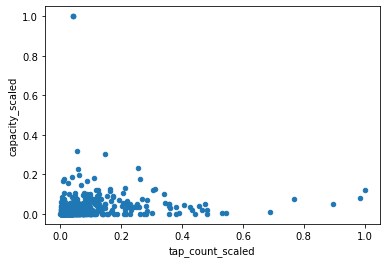

In [31]:
# Plot scaled entry counts and parking capacity by rail station.
stations[['tap_count_scaled',
               'capacity_scaled']].plot.scatter(x='tap_count_scaled',
                                                y='capacity_scaled')

In [32]:
# Calculate parking capacity per entry and naively scale.
stations['capacity_per_tap'] = stations['capacity'] / stations['tap_count']
stations = scale(stations, 'capacity_per_tap')
stations['capacity_per_tap_scaled'].describe()

count    489.000000
mean       0.042425
std        0.112483
min        0.000000
25%        0.000000
50%        0.008295
75%        0.031636
max        1.000000
Name: capacity_per_tap_scaled, dtype: float64

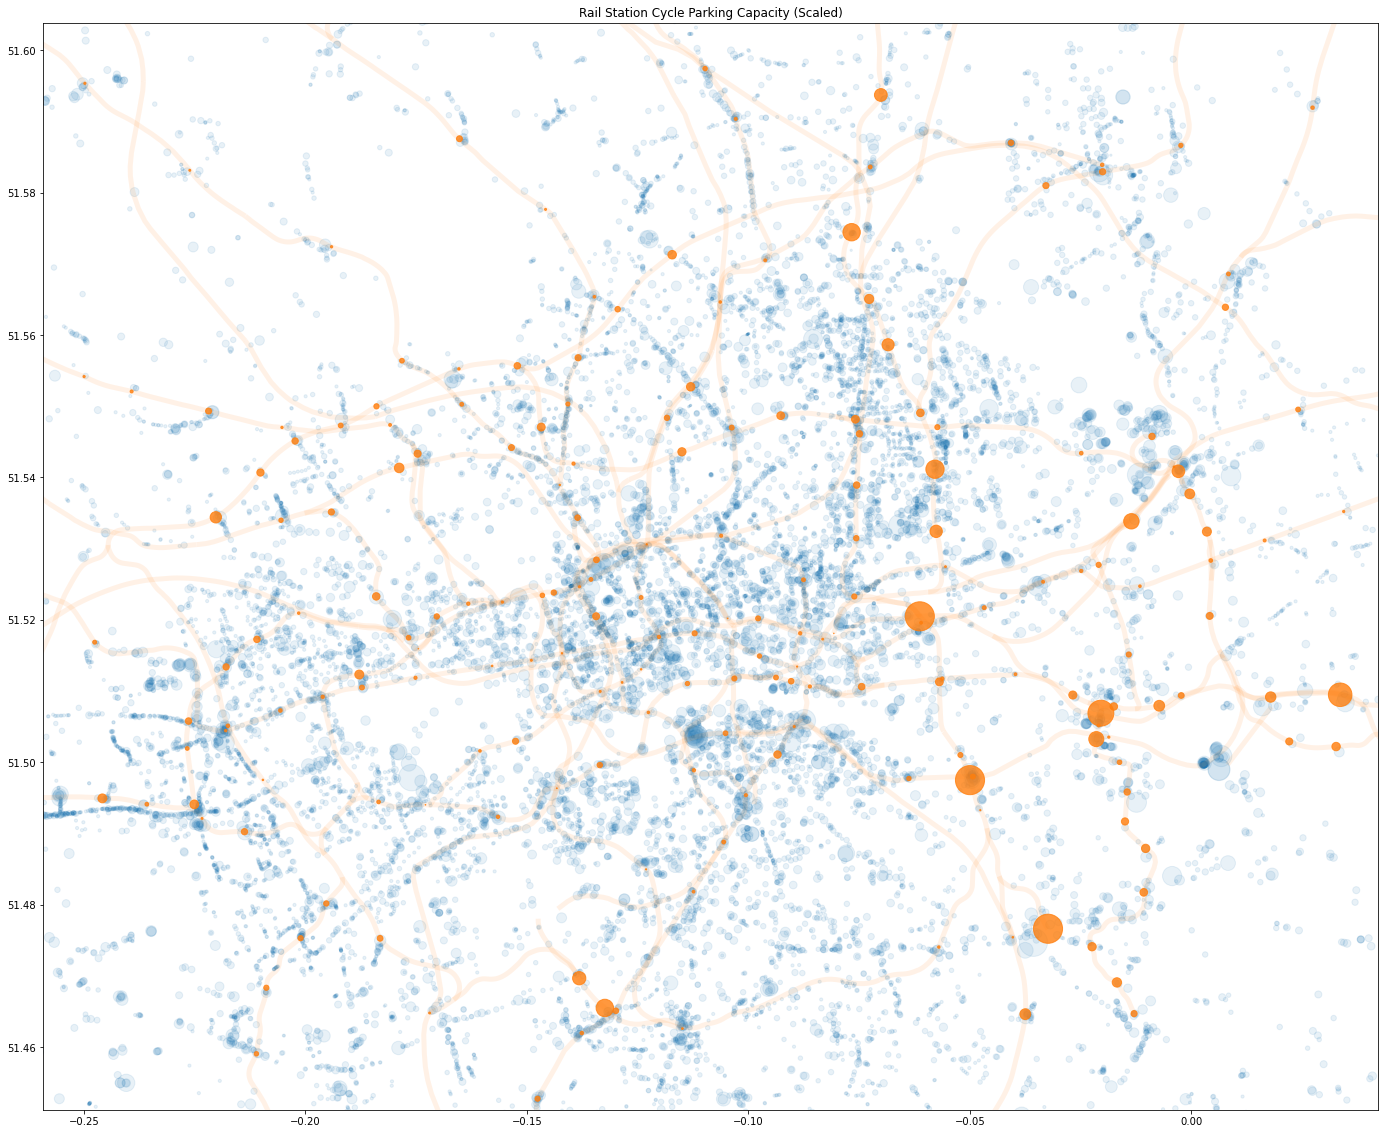

In [34]:
# Plot scaled parking capacity per entry for each rail station.
fig, ax = plt.subplots(figsize=(30, 20))

plot_background(ax)
stations.plot(ax=ax, markersize=stations['capacity_per_tap_scaled'] * MARKER_SIZE_STATIONS * 10, alpha=ALPHA_STATIONS, color=COLOR_STATIONS)
ax.set_title('Rail Station Cycle Parking Capacity (Scaled)')
plt.draw()

In [35]:
# Clean entry data for date comparison.
taps_2020 = taps_entry.copy()[['nlc_id', 'name', 'date', 'tap_count']]
taps_2020['date'] = taps_2020['date'].apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y', errors='ignore')).astype('datetime64[D]')
taps_2020.head()

,nlc_id,name,date,tap_count
2,750,Abbey Road DLR,2020-01-01,229
5,750,Abbey Road DLR,2020-02-01,430
8,750,Abbey Road DLR,2020-03-01,461
11,750,Abbey Road DLR,2020-04-01,356
12,750,Abbey Road DLR,2020-05-01,260


In [36]:
# Split entry data into before and after lockdown periods.
DATE_MID = pd.to_datetime('03/23/2020')
DATE_BEFORE = pd.to_datetime('01/01/2020')
DATE_PERIOD = (DATE_MID - DATE_BEFORE) 

DATE_COMPARE_CENTER = DATE_MID
DATE_COMPARE_START = DATE_COMPARE_CENTER - DATE_PERIOD
DATE_COMPARE_END = DATE_COMPARE_CENTER + DATE_PERIOD
print(DATE_COMPARE_START, DATE_COMPARE_CENTER, DATE_COMPARE_END)

taps_2020['date'].dtype
taps_before = taps_2020[(taps_2020['date'] >= DATE_COMPARE_START) & (taps_2020['date'] < DATE_COMPARE_CENTER)].sort_values(by=['date', 'nlc_id']).reset_index()
taps_after = taps_2020[(taps_2020['date'] >= DATE_COMPARE_CENTER) & (taps_2020['date'] < DATE_COMPARE_END)].sort_values(by=['date', 'nlc_id']).reset_index()

2020-01-01 00:00:00 2020-03-23 00:00:00 2020-06-13 00:00:00


In [37]:
# Aggregate entries for comparison periods.
taps_before_agg = taps_before.groupby(['nlc_id']).agg({
    'tap_count': 'sum',
    'name': 'first',
}).sort_values(by=['tap_count'], ascending=False).reset_index()
taps_after_agg = taps_after.groupby(['nlc_id']).agg({
    'tap_count': 'sum',
    'name': 'first',
}).sort_values(by=['tap_count'], ascending=False).reset_index()

<AxesSubplot:>

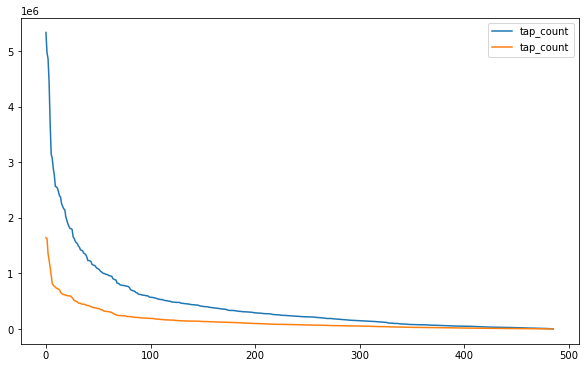

In [38]:
# Plot entries for comparison periods.
fig, ax = plt.subplots(figsize=(10, 6))

taps_before_agg[['tap_count']].plot(ax=ax)
taps_after_agg[['tap_count']].plot(ax=ax)

<AxesSubplot:>

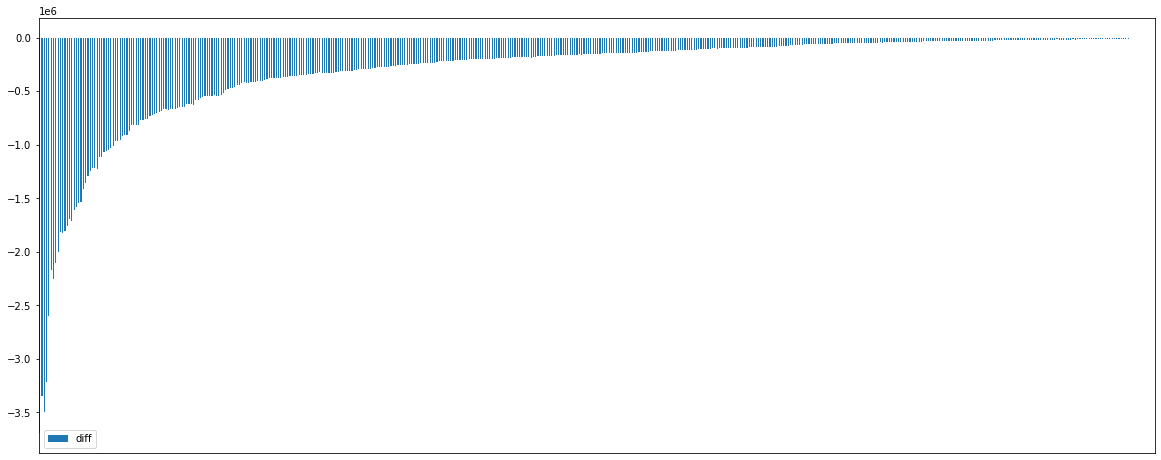

In [39]:
# Plot differences in entries between comparison periods.
fig, ax = plt.subplots(figsize=(20, 8))

taps_diff_agg = taps_before_agg.copy()
taps_diff_agg[['diff']] = (taps_after_agg[['tap_count']] - taps_before_agg[['tap_count']])
plt.tick_params(
    axis='x',        
    which='both',   
    bottom=False,  
    top=False,    
    labelbottom=False)

taps_diff_agg[['diff']].plot.bar(ax=ax)

In [57]:
# Merge differences with station capacities and remove outliers.
comparison = stations[['nlc_id', 'capacity', 'geometry']].copy()
comparison = comparison.merge(taps_diff_agg, on='nlc_id', how='inner')
comparison = scale(comparison, 'tap_count')
comparison = comparison[(comparison['capacity'] > 0) & (comparison['capacity'] < 500)]
comparison.head()

,nlc_id,capacity,geometry,tap_count,name,diff,diff_scaled,tap_count_scaled
1,508,18.0,POINT (-0.13475 51.56537),685986,Archway,-473474,0.871775,0.128344
3,507,38.0,POINT (-0.10613 51.53182),1234574,Angel,-810958,0.780412,0.231176
5,505,14.0,POINT (-0.29945 51.54055),202104,Alperton,-134594,0.963517,0.037640
9,530,8.0,POINT (-0.01159 51.52474),324017,Bromley-by-Bow,-208971,0.943381,0.060493
10,501,50.0,POINT (-0.09779 51.52021),675781,Barbican,-464811,0.874120,0.126431


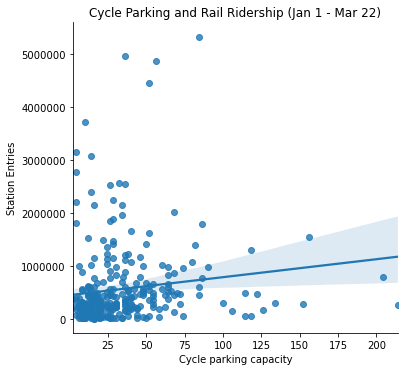

In [58]:
# Plot capacity vs. entries pre-lockdown.
ax = sns.lmplot(x='capacity', y='tap_count', data=comparison, fit_reg=True)
ax.set(xlabel='Cycle parking capacity', ylabel='Station Entries',title='Cycle Parking and Rail Ridership (Jan 1 - Mar 22)')
plt.ticklabel_format(style='plain', axis='y')

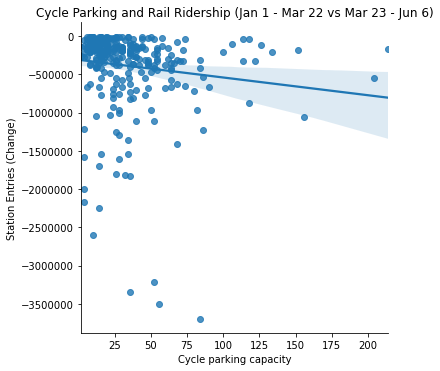

In [59]:
# Plot capacity vs. change in entries post-lockdown.
ax = sns.lmplot(x='capacity', y='diff', data=comparison, fit_reg=True) 
ax.set(xlabel='Cycle parking capacity', ylabel='Station Entries (Change)',title='Cycle Parking and Rail Ridership (Jan 1 - Mar 22 vs Mar 23 - Jun 6)')
plt.ticklabel_format(style='plain', axis='y')

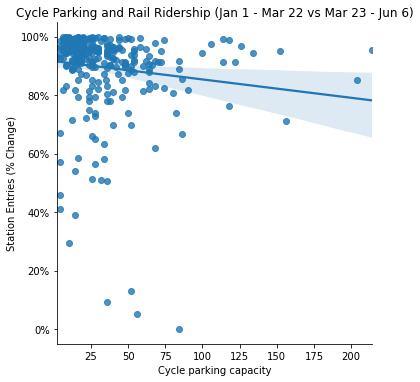

In [65]:
# Plot capacity vs. % change in entries post-lockdown.
from matplotlib.ticker import PercentFormatter
comparison_truncated = comparison[['capacity', 'diff_scaled']][comparison['diff_scaled'] < 5]

lm = sns.lmplot(x='capacity', y='diff_scaled', data=comparison_truncated, fit_reg=True) 
lm.set(xlabel='Cycle parking capacity', ylabel='Station Entries (% Change)',title='Cycle Parking and Rail Ridership (Jan 1 - Mar 22 vs Mar 23 - Jun 6)')
ax = lm.axes[0, 0]
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(PercentFormatter(1))